In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from utils.tf_mcc import MCC

In [3]:
# load training and validation sets

X_train = pd.read_csv("dataset/X_train.csv")
X_val = pd.read_csv("dataset/X_val.csv")
y_train = pd.read_csv("dataset/y_train.csv")
y_val = pd.read_csv("dataset/y_val.csv")

# load test set
X_test = pd.read_csv("dataset/X_test.csv")
y_test = pd.read_csv("dataset/y_test.csv")

In [4]:
# getting statistics of the title feature

# number of words per title
title_lengths = X_train.title.map(lambda x: len(x.split()))
title_lengths.describe()

count    26562.000000
mean        12.410210
std          4.077117
min          1.000000
25%         10.000000
50%         11.000000
75%         14.000000
max         42.000000
Name: title, dtype: float64

In [5]:
X_train = X_train['title'].values
X_val = X_val['title'].values
X_test = X_test['title'].values

y_train = y_train['classification'].values
y_val = y_val['classification'].values
y_test = y_test['classification'].values

In [20]:
# model parameters
vocabulary_size = 10000 # maximum vocabulary size (max_features, maximum number of tokens)
max_len = 20 # sequence length to pad the outputs to
embedding_dim = 16

# create vocab layer
# instantiate the text vectorization layer
vectorize_layer = layers.TextVectorization(max_tokens = vocabulary_size, 
                                    standardize = "lower_and_strip_punctuation", 
                                    output_mode = "int", 
                                    output_sequence_length = max_len)

# build the vocabulary
# vectorization layer that generates a tensor of shape (batch_size, max_len) containing vocabulary indices
vectorize_layer.adapt(X_train)

# vectorize_layer.get_vocabulary()
# vectorize_layer.vocabulary_size()

In [21]:
train_text = vectorize_layer(X_train)
val_text = vectorize_layer(X_val)
test_text = vectorize_layer(X_test)

In [22]:
train_text

<tf.Tensor: shape=(26562, 20), dtype=int64, numpy=
array([[   3,  750, 5840, ...,    0,    0,    0],
       [  86,   54,  747, ...,    0,    0,    0],
       [  27,    3,  249, ...,    0,    0,    0],
       ...,
       [ 974,   88, 2558, ...,    0,    0,    0],
       [3295,  113,  234, ...,    0,    0,    0],
       [  33, 4164, 8185, ...,    0,    0,    0]])>

In [23]:
# train_text.shape

In [24]:
model = Sequential([
    tf.keras.Input(shape = (max_len,), dtype = tf.int64),
    layers.Embedding(vocabulary_size + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(units = 1),
]
)

In [25]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 20, 16)         │       160,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,033 (625.13 KB)

 Trainable params: 160,033 (625.13 KB)

 Non-trainable params: 0 (0.00 B)

### train the model

In [26]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True), 
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
    metrics = [tf.keras.metrics.BinaryAccuracy(), 
               tf.keras.metrics.Precision(), 
               tf.keras.metrics.Recall(), 
#                MCC(),
              ],
)


early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, 
                                              restore_best_weights = True)



history = model.fit(
        train_text, y_train,
        validation_data = (val_text, y_val),
        epochs = 500,
        callbacks = [early_stop],
)

Epoch 1/500
831/831 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - binary_accuracy: 0.7277 - loss: 0.5519 - precision_1: 0.8571 - recall_1: 0.4895 - val_binary_accuracy: 0.9017 - val_loss: 0.2677 - val_precision_1: 0.9366 - val_recall_1: 0.8590
Epoch 2/500
831/831 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.9216 - loss: 0.2375 - precision_1: 0.9310 - recall_1: 0.9040 - val_binary_accuracy: 0.9373 - val_loss: 0.1744 - val_precision_1: 0.9494 - val_recall_1: 0.9222
Epoch 3/500
831/831 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.9500 - loss: 0.1557 - precision_1: 0.9537 - recall_1: 0.9418 - val_binary_accuracy: 0.9442 - val_loss: 0.1421 - val_precision_1: 0.9679 - val_recall_1: 0.9174
Epoch 4/500
831/831 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.9595 - loss: 0.1218 - precision_1: 0.9640 - recall_1: 0.9508 - val_binary_accuracy: 0.9573 - val_loss: 0.1184 - val_precision_1: 0.9659 - val_recall_1: 0.9469
Epoch 5/500
831/831 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accura

### save vectorizer and model

In [44]:
# instantiate keras tensor stating the shape and type of the input
text_input = tf.keras.Input(shape = (1,), dtype = tf.string, name = "text_input")
vectorized = vectorize_layer(text_input)


logits = model(vectorized)
output_probs = layers.Activation("sigmoid")(logits)

full_model = tf.keras.Model(text_input, output_probs)

In [48]:
full_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True), 
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
    metrics = [tf.keras.metrics.BinaryAccuracy(), 
               tf.keras.metrics.Precision(), 
               tf.keras.metrics.Recall(), 
#                MCC(),
              ],
)

In [49]:
full_model.save("model/fake_news_classifier/model.keras")

In [47]:
history.history

{'binary_accuracy': [0.8301709294319153,
  0.9283939599990845,
  0.9502296447753906,
  0.9600933790206909,
  0.9676605463027954,
  0.9724418520927429,
  0.9761313199996948,
  0.9786913394927979,
  0.9808749556541443,
  0.983359694480896,
  0.9848279356956482,
  0.9857691526412964,
  0.9868986010551453,
  0.9880279898643494,
  0.9895339012145996,
  0.9905880689620972,
  0.991679847240448],
 'loss': [0.43677181005477905,
  0.21440348029136658,
  0.14976654946804047,
  0.11758728325366974,
  0.0983622819185257,
  0.08380138128995895,
  0.07223473489284515,
  0.0644761398434639,
  0.05811339616775513,
  0.05142342299222946,
  0.04647733271121979,
  0.042179007083177567,
  0.03865218162536621,
  0.03517903760075569,
  0.03254483640193939,
  0.02995600923895836,
  0.027100851759314537],
 'precision_1': [0.9049530029296875,
  0.9375251531600952,
  0.9544121026992798,
  0.9641358852386475,
  0.9714579582214355,
  0.9767423272132874,
  0.9800110459327698,
  0.9821640253067017,
  0.9842997789382

### performance of the training and validation sets

In [31]:
history.history.keys()

dict_keys(['binary_accuracy', 'loss', 'precision_1', 'recall_1', 'val_binary_accuracy', 'val_loss', 'val_precision_1', 'val_recall_1'])

In [33]:
epochs = history.epoch

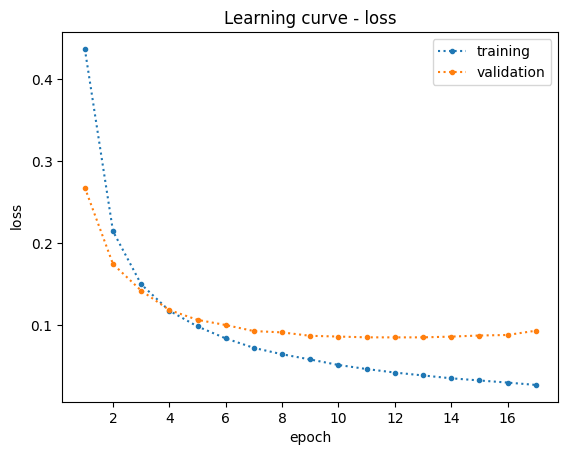

In [34]:
plt.plot(range(1, max(epochs) + 2), history.history['loss'], ".:")
plt.plot(range(1, max(epochs) + 2), history.history['val_loss'], ".:")

plt.title('Learning curve - loss')
plt.legend(['training', 'validation'], loc = "best")
plt.ylabel(r"$\mathrm{loss}$")
plt.xlabel("epoch")
# plt.xticks(range(1, max(epochs) + 2))
plt.show()

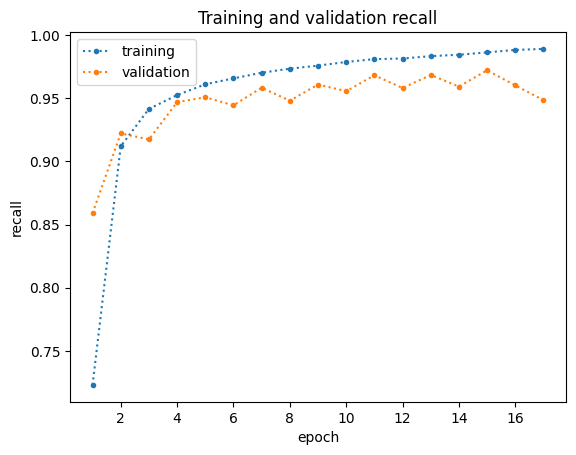

In [35]:
plt.plot(range(1, max(epochs) + 2), history.history["recall_1"], ".:")
plt.plot(range(1, max(epochs) + 2), history.history["val_recall_1"], ".:")

plt.title('Training and validation recall')
plt.legend(['training', 'validation'], loc = "best")
plt.ylabel("recall")
plt.xlabel("epoch")
# plt.xticks(range(1, max(epochs) + 2))
plt.show()

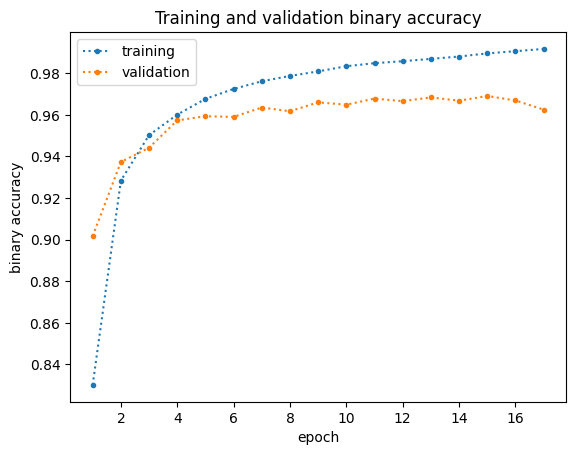

In [36]:
plt.plot(range(1, max(epochs) + 2), history.history['binary_accuracy'], ".:")
plt.plot(range(1, max(epochs) + 2), history.history['val_binary_accuracy'], ".:")

plt.title('Training and validation binary accuracy')
plt.legend(['training', 'validation'], loc = "best")
plt.ylabel("binary accuracy")
plt.xlabel("epoch")
# plt.xticks(range(1, max(epochs) + 2))
plt.show()

In [ ]:
# plt.plot(range(1, max(epochs) + 2), history.history['mcc'], ".:")
# plt.plot(range(1, max(epochs) + 2), history.history['val_mcc'], ".:")

# plt.title('Training and validation MCC')
# plt.legend(['training', 'validation'], loc = "best")
# plt.ylabel("mcc")
# plt.xlabel("epoch")
# plt.xticks(range(1, max(epochs) + 2))
# plt.show()

###### model performance on the test set

In [37]:
y_pred = model.predict(test_text)

277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step


In [38]:
y_pred.shape

(8855, 1)

In [39]:
y_pred > 0.5

array([[False],
       [False],
       [ True],
       ...,
       [ True],
       [False],
       [ True]])

In [40]:
evaluation = model.evaluate(x = test_text, y = y_test, return_dict = True)

277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - binary_accuracy: 0.9672 - loss: 0.0926 - precision_1: 0.9717 - recall_1: 0.9605


In [41]:
evaluation.items()

dict_items([('binary_accuracy', 0.9661208391189575), ('loss', 0.08795332163572311), ('precision_1', 0.9709869027137756), ('recall_1', 0.9582257866859436)])

In [42]:
for metric, value in evaluation.items():
    print(f"{metric}: {value:.4f}")

binary_accuracy: 0.9661
loss: 0.0880
precision_1: 0.9710
recall_1: 0.9582
